# Deep Learning Architectures: GANs
# Caelan Osman
# April 11, 2022

In [1]:
from google.colab import files
import glob
import os
import gzip
import tarfile    
import time
import torch
from torchvision import datasets                  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We will be building a GAN that can come up with realistic images. We will be using the MNIST dataset. 

In [2]:
def download_data(shuffle=True):
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()) 
    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()) 


    train_loader = DataLoader(mnist_trainset, batch_size=32, shuffle=shuffle)
    test_loader = DataLoader(mnist_testset, batch_size=1, shuffle=shuffle)


    return train_loader, test_loader 

train_loader, test_loader = download_data(shuffle=True)

In [3]:
class Discriminator(nn.Module):
    """
    Discriminator in GAN
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class Generator(nn.Module):
    """
    Generator in GAN
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

Training:

In [5]:
# instantiat discrimanator and Generator NN
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)
# instantiate the optimizers 
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)

# loss function, we will be using the binary classification, 
# cross entropy loss function
loss = nn.BCELoss()
epochs = 30
mean_loss_D = []
mean_loss_G = []
for epoch in range(epochs):
    loop = tqdm(total=len(train_loader), position=0)
    epoch_loss_D = []
    epoch_loss_G = []
    for idx, (imgs, _) in enumerate(train_loader):

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        epoch_loss_D.append(D_loss.item())

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        epoch_loss_G.append(G_loss.item())


        loop.set_description("G loss: {:.4f}, D loss: {:.4f}".format(G_loss, D_loss))
        loop.update()

    mean_loss_D.append(np.mean(epoch_loss_D))
    mean_loss_G.append(np.mean(epoch_loss_G))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

G loss: 49.4797, D loss: 0.0000: 100%|█████████▉| 1874/1875 [00:25<00:00, 80.73it/s]

Model saved.


G loss: 100.0000, D loss: 0.0000: 100%|█████████▉| 1874/1875 [00:22<00:00, 82.74it/s]

Model saved.


G loss: 100.0000, D loss: 0.0000: 100%|█████████▉| 1874/1875 [00:22<00:00, 81.34it/s]

Model saved.


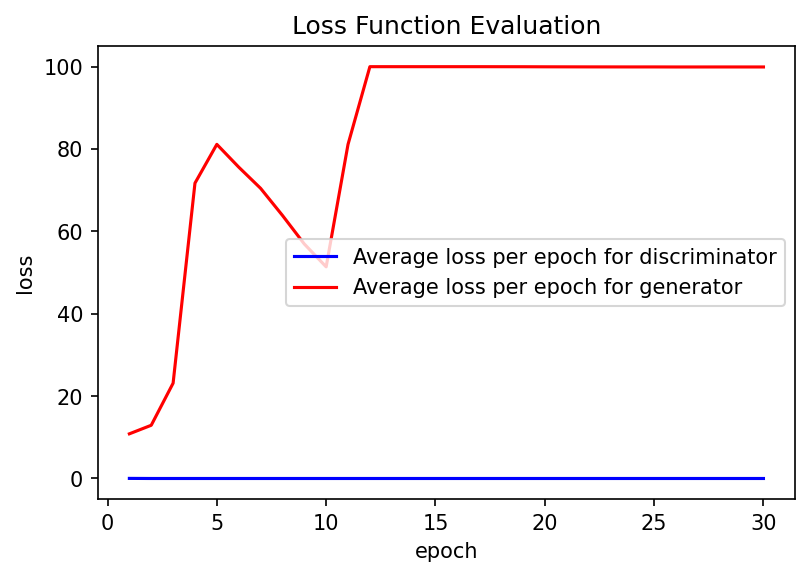

In [6]:
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)
ax.plot(np.arange(1, 31), mean_loss_D, 'b-', label='Average loss per epoch for discriminator')
ax.plot(np.arange(1, 31), mean_loss_G, 'r-', label='Average loss per epoch for generator')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='best')
ax.set_title("Loss Function Evaluation")
plt.show()

We can now generate random images

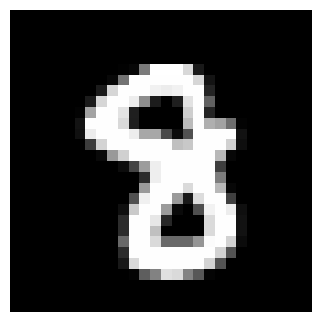

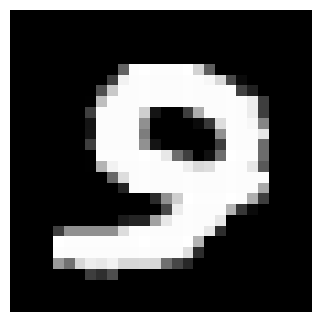

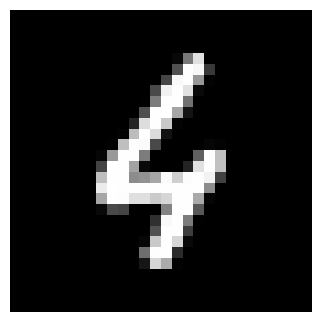

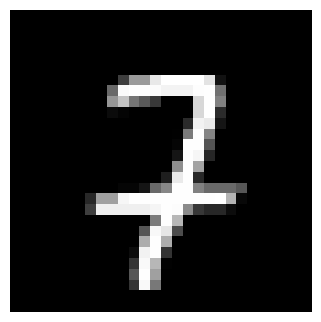

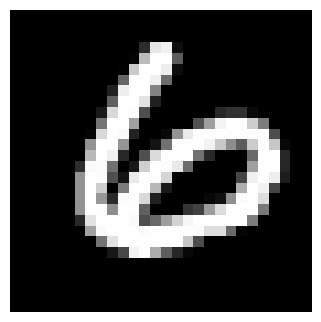

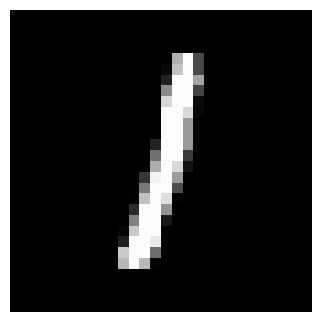

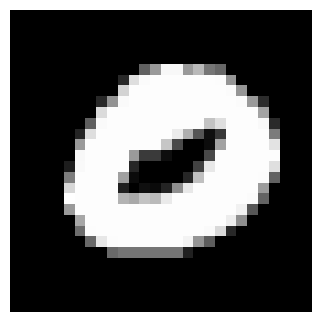

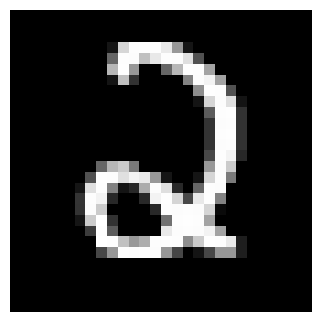

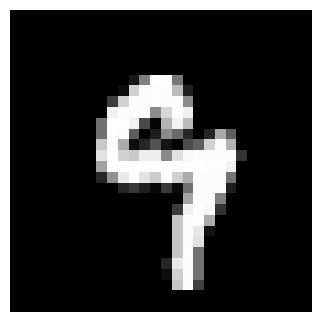

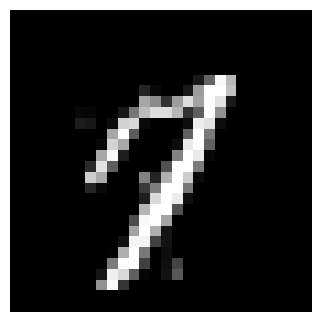

Accuracy on Real Images (we want this to be close to 1): 0.9997
Accuracy on Fake Images (we want this to be close to 1): 0.00029999999999996696


In [15]:
G.eval()
D.eval()

D_accuracy_real =  0

for idx, (imgs, _) in enumerate(test_loader):
    # real input
    real_inputs = imgs.to(device)
    # real output (what the deiscriminator labels it as)
    real_outputs = D(real_inputs)
    # real labels
    real_label = torch.ones(real_inputs.shape[0], 1).to(device)

    D_accuracy_real += (real_label == real_outputs).sum().item()


    noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
    noise = noise.to(device)

    # plot some generated iages
    if idx < 10:
        fig = plt.figure()
        fig.set_dpi(100)
        plt.imshow(real_inputs.squeeze().detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.show()


    fake_inputs = G(noise)
    fake_outputs = D(fake_inputs)
    fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

    outputs = torch.cat((real_outputs, fake_outputs), 0)
    targets = torch.cat((real_label, fake_label), 0)

D_accuracy_real /= 10000



print('Accuracy on Real Images (we want this to be close to 1): {}'.format(D_accuracy_real))
print('Accuracy on Fake Images (we want this to be close to 1): {}'.format(1-D_accuracy_real))